In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [24]:
from pandas import read_csv
from datetime import datetime
# load data

def parse(*args): 
    return datetime.strptime(str(args[0])+ " " + str(args[1]) , '%d/%m/%Y %H:%M:%S')
dataset = read_csv('/content/drive/My Drive/originaldataset/O3sensor - O3 (1) (1) (1).csv', index_col=0)
#print( dataset.head())
#dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['O3(SENSOR)']
dataset.index.name = 'DATE'
# mark all NA values with 0
# dataset['DATE'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('/content/drive/My Drive/originaldataset/O3sensor - O3 (1) (1) (1).csv')

                     O3(SENSOR)
DATE                           
2020-04-08 08:30:00       56.29
2020-04-08 08:45:00       56.29
2020-04-08 09:00:00       50.04
2020-04-08 09:15:00       50.91
2020-04-08 09:30:00       51.35


In [25]:
cd /content/drive/My Drive/

/content/drive/My Drive


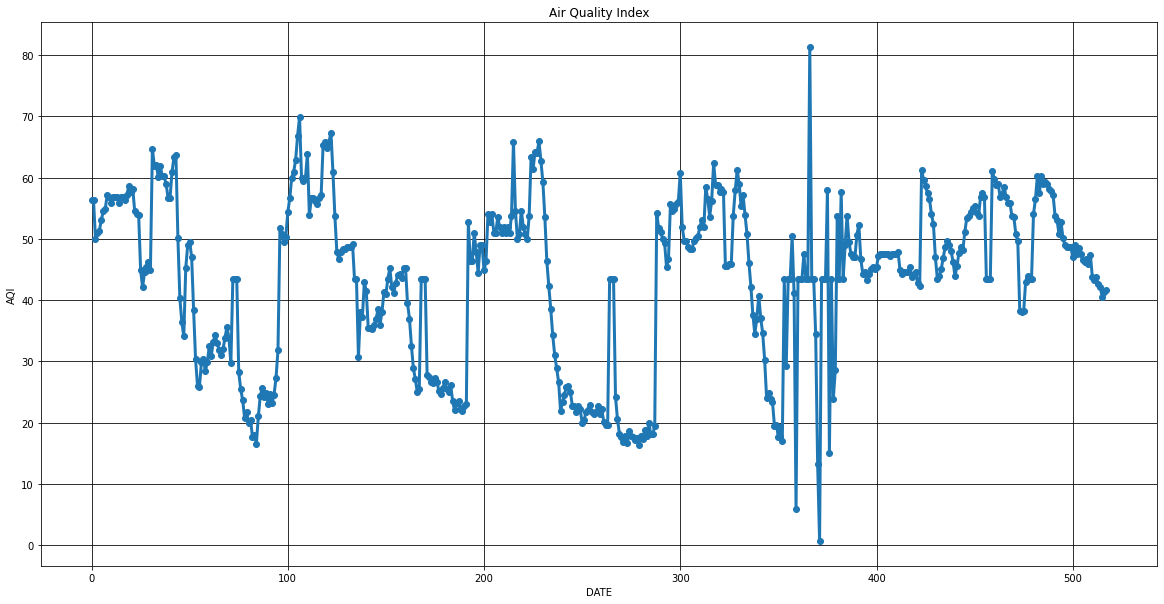

In [26]:
from pandas import read_csv
import matplotlib.pyplot as plt

from matplotlib import pyplot
import pandas as pd
# load dataset
dataset =pd.read_csv('/content/drive/My Drive/originaldataset/O3sensor - O3 (1) (1) (1).csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
# groups = [1]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()


plt.figure(figsize=(20,10))
plt.xlabel("DATE")
plt.ylabel("AQI")
plt.title('Air Quality Index')
plt.plot(values, marker='o', label='Air Quality Index', linewidth=3)
plt.grid(color='black')

In [42]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i));  #      print(df.shift(-i).head())
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('/content/drive/My Drive/originaldataset/O3sensor - O3 (1) (1) (1).csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#print(scaled[:5])
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
# print(reframed.head())
# reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
# print(reframed.head())

In [43]:
train=0.97
test=0.03
# split into train and test sets
values = reframed.values
n_train_hours = int(reframed.shape[0]*train)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print(train_y[:5])

(501, 1, 1) (501, 1) (16, 1, 1) (16, 1)


In [44]:

from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
11/11 - 0s - loss: 0.4745 - val_loss: 0.4270
Epoch 2/100
11/11 - 0s - loss: 0.3750 - val_loss: 0.3326
Epoch 3/100
11/11 - 0s - loss: 0.2819 - val_loss: 0.2312
Epoch 4/100
11/11 - 0s - loss: 0.1984 - val_loss: 0.1336
Epoch 5/100
11/11 - 0s - loss: 0.1410 - val_loss: 0.0451
Epoch 6/100
11/11 - 0s - loss: 0.1055 - val_loss: 0.0232
Epoch 7/100
11/11 - 0s - loss: 0.0972 - val_loss: 0.0482
Epoch 8/100
11/11 - 0s - loss: 0.0971 - val_loss: 0.0525
Epoch 9/100
11/11 - 0s - loss: 0.0957 - val_loss: 0.0472
Epoch 10/100
11/11 - 0s - loss: 0.0940 - val_loss: 0.0559
Epoch 11/100
11/11 - 0s - loss: 0.0936 - val_loss: 0.0546
Epoch 12/100
11/11 - 0s - loss: 0.0916 - val_loss: 0.0537
Epoch 13/100
11/11 - 0s - loss: 0.0932 - val_loss: 0.0500
Epoch 14/100
11/11 - 0s - loss: 0.0896 - val_loss: 0.0167
Epoch 15/100
11/11 - 0s - loss: 0.0898 - val_loss: 0.0164
Epoch 16/100
11/11 - 0s - loss: 0.0886 - val_loss: 0.0478
Epoch 17/100
11/11 - 0s - loss: 0.0874 - val_loss: 0.0439
Epoch 18/100
11/11 - 0s

In [45]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[2]))
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[2]))

In [46]:
print(test_X.shape)
print(train_X.shape)



(16, 1, 1)
(501, 1, 1)


In [47]:
yhat = model.predict(test_X)
#yhat = model.predict(train_X)
print(yhat[:5])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
print(test_y[:,-1:])
#print(train_y[:,-1:])
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = concatenate((yhat, train_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat[:5])
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
#train_y = train_y.reshape((len(train_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y[:5])
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)



[[0.61389196]
 [0.5959379 ]
 [0.6066755 ]
 [0.5959379 ]
 [0.58183324]]
[[0.5818858 ]
 [0.5924317 ]
 [0.5818858 ]
 [0.56799   ]
 [0.56451607]
 [0.57146394]
 [0.5611662 ]
 [0.5784119 ]
 [0.53411907]
 [0.52741927]
 [0.53411907]
 [0.5208436 ]
 [0.514268  ]
 [0.4949131 ]
 [0.5045905 ]
 [0.5078164 ]]
[50.179695 48.7326   49.59805  48.7326   47.595764]
[47.600002 48.45     47.600002 46.48     46.199997]
Test RMSE: 1.970


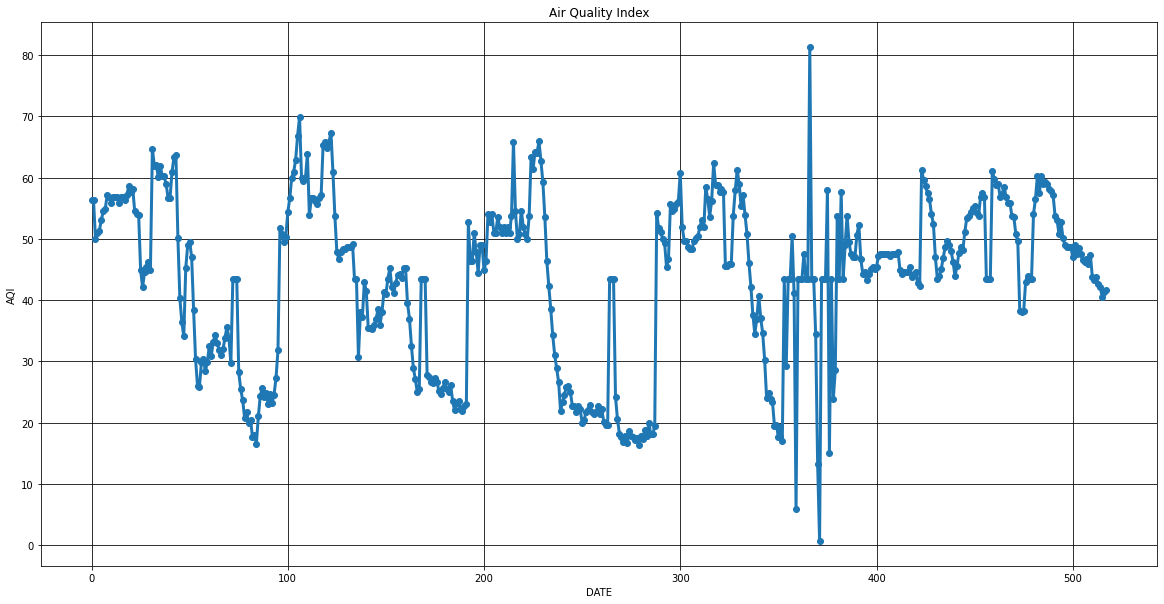

In [49]:
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd
# load dataset
dataset =pd.read_csv('/content/drive/My Drive/originaldataset/O3sensor - O3 (1) (1) (1).csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
# groups = [1]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()


plt.figure(figsize=(20,10))
plt.xlabel("DATE")
plt.ylabel("AQI")
plt.title('Air Quality Index')
plt.plot(values, marker='o', label='Air Quality Index', linewidth=3)
plt.grid(color='black')

In [60]:

inv_y[:15]

array([47.600002, 48.45    , 47.600002, 46.48    , 46.199997, 46.76    ,
       45.93    , 47.32    , 43.75    , 43.209995, 43.75    , 42.68    ,
       42.15    , 40.59    , 41.37    ], dtype=float32)

In [55]:
inv_yhat[:15]


array([50.179695, 48.7326  , 49.59805 , 48.7326  , 47.595764, 47.312183,
       47.879597, 47.03898 , 48.448017, 44.84164 , 44.299717, 44.84164 ,
       43.768764, 43.23872 , 41.683907], dtype=float32)